### First, load the evaluation wind processes

In [19]:
import numpy as np
from config import *
from tqdm import tqdm
from wind_processes import SetSequenceWindProcess
from PIL import Image

# Settings
VERBOSE_EVAL = False

# Load wind data
wind_directions = np.load("data/eval/wind_directions.npy")
wind_speeds = np.load("data/eval/wind_speeds.npy")
fixed_wind_directions = [[wind_directions[i,0] for j in range(len(wind_directions[0]))]for i in range(len(wind_directions))]
fixed_wind_speeds = [[wind_speeds[i,0] for j in range(len(wind_speeds[0]))]for i in range(len(wind_speeds))]

# List from 270        
render_wind_directions = np.concatenate((
            np.ones((10))*270,
            np.linspace(270, 250, 20),
            np.linspace(250, 290, 40),
            np.linspace(290, 250, 20),
            np.linspace(250, 270, 11),
        ))
render_wind_speeds = np.ones_like(render_wind_directions) * 8.0

# Render for fixed wind environment
fw_render_speed = np.ones_like(render_wind_directions) * 8.0
fw_render_direction = np.ones_like(render_wind_directions) * 270.0

def evaluate_model(env, agent_fn, wind_directions=wind_directions, wind_speeds=wind_speeds, EVAL_REPS=EVAL_REPS, EPISODE_LEN=EPISODE_LEN):
    total_rewards = np.zeros((EVAL_REPS, EPISODE_LEN))
    total_powers = np.zeros((EVAL_REPS, EPISODE_LEN))
    for i in tqdm.tqdm(range(EVAL_REPS)):
        env.wind_process = SetSequenceWindProcess(wind_directions=wind_directions[i], wind_speeds=wind_speeds[i])
        env._np_random, env._seed = env.seed(0)
        obs, info = env.reset()
        for j in range(EPISODE_LEN):
            action = agent_fn(env, obs)
            obs, reward, terminated, truncated, info = env.step(action)

            total_rewards[i, j] = reward
            total_powers[i, j] = info["power_output"]

            if terminated or truncated:
                break
        if VERBOSE_EVAL:
            print("Episode {} finished with reward {}".format(i, np.sum(total_rewards[i])))
            print("Episode {} finished with power {}".format(i, np.sum(total_powers[i])))
        env.reset()
    return total_rewards, total_powers

def render_model(env, agent_fn, wind_directions=render_wind_directions, wind_speeds=render_wind_speeds, EPISODE_LEN=EPISODE_LEN):
    env.wind_process = SetSequenceWindProcess(wind_speeds=wind_speeds, wind_directions=wind_directions)
    obs, info = env.reset()
    video = []
    for j in range(EPISODE_LEN):
        action = agent_fn(env, obs)
        obs, reward, terminated, truncated, info = env.step(action)
        f = env.render(mode="rgb_array")
        video.append(f)
    video = [Image.fromarray(img) for img in video]
    return video

def get_propSR_action(agent):
    return lambda env, obs: agent.predict(env.wind_process.wind_direction, env.yaws_from_wind)

def get_noisy_propSR_action(agent):
    return lambda env, obs: agent.predict(env.wind_process.wind_direction + np.random.normal(0, 5), env.yaws_from_wind)

def get_model_action(model):
    return lambda env, obs: model.predict(obs, deterministic=True)[0]

def get_nondeterministic_model_action(model):
    return lambda env, obs: model.predict(obs, deterministic=False)[0]

def get_naive_action():
    return lambda env, obs: 0

def get_random_action():
    return lambda env, obs: env.action_space.sample()

def save_scores_and_render(exp_name, env, agent_fn, wind_directions=wind_directions, wind_speeds=wind_speeds, render_wind_directions=render_wind_directions, render_wind_speeds=render_wind_speeds, EVAL_REPS=EVAL_REPS, EPISODE_LEN=EPISODE_LEN):
    print(f"Evaluating model {exp_name}")
    video = render_model(env, agent_fn, render_wind_directions, render_wind_speeds, EPISODE_LEN)
    video[0].save(f"data/eval/renders/{exp_name}.gif", save_all=True, append_images=video[1:], loop=0, duration=1000/30)
    total_rewards, total_powers = evaluate_model(env, agent_fn, wind_directions, wind_speeds, EVAL_REPS, EPISODE_LEN)
    np.save(f"data/eval/scores/{exp_name}_total_rewards.npy", total_rewards)
    np.save(f"data/eval/scores/{exp_name}_total_powers.npy", total_powers)

### [FW] 4wt fixed wind results | PropSR, Naive, Random

In [ ]:
from serial_refine_agent import SR_ProportionalController
from env_utils import get_4wt_symmetric_env
from config import EPISODE_LEN, EVAL_REPS
from wind_processes import SetSequenceWindProcess

import numpy as np
import tqdm
from PIL import Image

# Load environment
env = get_4wt_symmetric_env(episode_length=EPISODE_LEN, privileged=False, changing_wind=True, action_representation="yaw",
    load_pyglet_visualization=True)

#### Proportional SR 
save_scores_and_render("FW_PropSR", env, get_propSR_action(SR_ProportionalController()), wind_directions=fixed_wind_directions, wind_speeds=fixed_wind_speeds, render_wind_directions=fw_render_direction, render_wind_speeds=fw_render_speed)

# Load environment
env = get_4wt_symmetric_env(episode_length=EPISODE_LEN, privileged=False, changing_wind=True,
    load_pyglet_visualization=True)

#### Naive 
save_scores_and_render("FW_Naive", env, get_naive_action(), wind_directions=fixed_wind_directions, wind_speeds=fixed_wind_speeds, render_wind_directions=fw_render_direction, render_wind_speeds=fw_render_speed)
#### Random
save_scores_and_render("FW_Random", env, get_random_action(), wind_directions=fixed_wind_directions, wind_speeds=fixed_wind_speeds, render_wind_directions=fw_render_direction, render_wind_speeds=fw_render_speed)

Wind farm bounds (min, max): (0, 0) (250.0, 250.0)
Evaluating model FW_PropSR


100%|██████████| 10/10 [00:21<00:00,  2.14s/it]


Evaluating model FW_Naive


100%|██████████| 10/10 [00:21<00:00,  2.19s/it]


Evaluating model FW_Random


### [CW] PropSR, NoisyPropSR, Naive, Random

Wind farm bounds (min, max): (0, 0) (250.0, 250.0)


 10%|█         | 1/10 [00:01<00:12,  1.41s/it]

Episode 0 finished with reward 0.2086434451616809
Episode 0 finished with power 150223280.51641023


 20%|██        | 2/10 [00:02<00:11,  1.45s/it]

Episode 1 finished with reward 1.8297006732603611
Episode 1 finished with power 1317384484.74746


 30%|███       | 3/10 [00:04<00:10,  1.43s/it]

Episode 2 finished with reward 1.5237527490801577
Episode 2 finished with power 1097101979.3377135


 40%|████      | 4/10 [00:05<00:08,  1.41s/it]

Episode 3 finished with reward 1.7865043570770196
Episode 3 finished with power 1286283137.0954545


 50%|█████     | 5/10 [00:07<00:07,  1.41s/it]

Episode 4 finished with reward 1.1539442337397279
Episode 4 finished with power 830839848.2926042


 60%|██████    | 6/10 [00:08<00:05,  1.39s/it]

Episode 5 finished with reward 0.10191543701636027
Episode 5 finished with power 73379114.6517794


 70%|███████   | 7/10 [00:09<00:04,  1.38s/it]

Episode 6 finished with reward 2.310319234079802
Episode 6 finished with power 1663429848.5374577


 80%|████████  | 8/10 [00:11<00:02,  1.38s/it]

Episode 7 finished with reward 1.94226548342957
Episode 7 finished with power 1398431148.0692904


 90%|█████████ | 9/10 [00:12<00:01,  1.39s/it]

Episode 8 finished with reward 0.4103822484876196
Episode 8 finished with power 295475218.91108614


100%|██████████| 10/10 [00:14<00:00,  1.40s/it]

Episode 9 finished with reward 1.5366755621168782
Episode 9 finished with power 1106406404.7241523



 10%|█         | 1/10 [00:01<00:12,  1.34s/it]

Episode 0 finished with reward 0.2084532110064752
Episode 0 finished with power 150086311.9246622


 20%|██        | 2/10 [00:02<00:10,  1.37s/it]

Episode 1 finished with reward 1.8270615707131954
Episode 1 finished with power 1315484330.9135008


 30%|███       | 3/10 [00:04<00:09,  1.37s/it]

Episode 2 finished with reward 1.5186525428110924
Episode 2 finished with power 1093429830.8239868


 40%|████      | 4/10 [00:05<00:08,  1.37s/it]

Episode 3 finished with reward 1.777349015703683
Episode 3 finished with power 1279691291.306652


 50%|█████     | 5/10 [00:06<00:06,  1.37s/it]

Episode 4 finished with reward 1.152762607991215
Episode 4 finished with power 829989077.7536751


 60%|██████    | 6/10 [00:08<00:05,  1.35s/it]

Episode 5 finished with reward 0.10197907935726956
Episode 5 finished with power 73424937.13723408


 70%|███████   | 7/10 [00:09<00:04,  1.36s/it]

Episode 6 finished with reward 2.308762901610417
Episode 6 finished with power 1662309289.1595006


 80%|████████  | 8/10 [00:10<00:02,  1.36s/it]

Episode 7 finished with reward 1.9314329936560481
Episode 7 finished with power 1390631755.4323547


 90%|█████████ | 9/10 [00:12<00:01,  1.35s/it]

Episode 8 finished with reward 0.41012166389163984
Episode 8 finished with power 295287598.0019808


100%|██████████| 10/10 [00:13<00:00,  1.36s/it]

Episode 9 finished with reward 1.5314152017647111
Episode 9 finished with power 1102618945.270592
Wind farm bounds (min, max): (0, 0) (250.0, 250.0)



 10%|█         | 1/10 [00:01<00:11,  1.32s/it]

Episode 0 finished with reward 0.20290891169132216
Episode 0 finished with power 146094416.4177519


 20%|██        | 2/10 [00:02<00:10,  1.35s/it]

Episode 1 finished with reward 1.8094161567268754
Episode 1 finished with power 1302779632.8433504


 30%|███       | 3/10 [00:04<00:09,  1.35s/it]

Episode 2 finished with reward 1.51211364011258
Episode 2 finished with power 1088721820.8810575


 40%|████      | 4/10 [00:05<00:08,  1.35s/it]

Episode 3 finished with reward 1.7466335372304875
Episode 3 finished with power 1257576146.805951


 50%|█████     | 5/10 [00:06<00:06,  1.38s/it]

Episode 4 finished with reward 1.1495438162423766
Episode 4 finished with power 827671547.694511


 60%|██████    | 6/10 [00:08<00:05,  1.36s/it]

Episode 5 finished with reward 0.10017472818389758
Episode 5 finished with power 72125804.29240623


 70%|███████   | 7/10 [00:09<00:04,  1.37s/it]

Episode 6 finished with reward 2.302833348310389
Episode 6 finished with power 1658040010.7834802


 80%|████████  | 8/10 [00:10<00:02,  1.36s/it]

Episode 7 finished with reward 1.9102893618085346
Episode 7 finished with power 1375408340.502145


 90%|█████████ | 9/10 [00:12<00:01,  1.36s/it]

Episode 8 finished with reward 0.40802675062649185
Episode 8 finished with power 293779260.4510742


100%|██████████| 10/10 [00:13<00:00,  1.36s/it]

Episode 9 finished with reward 1.524126802851526
Episode 9 finished with power 1097371298.0530987



 10%|█         | 1/10 [00:01<00:11,  1.32s/it]

Episode 0 finished with reward 0.19697809046142697
Episode 0 finished with power 141824225.13222742


 20%|██        | 2/10 [00:02<00:10,  1.36s/it]

Episode 1 finished with reward 1.7704273695758512
Episode 1 finished with power 1274707706.0946128


 30%|███       | 3/10 [00:04<00:09,  1.37s/it]

Episode 2 finished with reward 1.4774676381043141
Episode 2 finished with power 1063776699.4351062


 40%|████      | 4/10 [00:05<00:08,  1.36s/it]

Episode 3 finished with reward 1.748698339230415
Episode 3 finished with power 1259062804.2458987


 50%|█████     | 5/10 [00:06<00:06,  1.37s/it]

Episode 4 finished with reward 1.128725559031784
Episode 4 finished with power 812682402.5028846


 60%|██████    | 6/10 [00:08<00:05,  1.36s/it]

Episode 5 finished with reward 0.09741613483309602
Episode 5 finished with power 70139617.07982914


 70%|███████   | 7/10 [00:09<00:04,  1.36s/it]

Episode 6 finished with reward 2.2945043010240918
Episode 6 finished with power 1652043096.7373466


 80%|████████  | 8/10 [00:10<00:02,  1.37s/it]

Episode 7 finished with reward 1.882855306639323
Episode 7 finished with power 1355655820.7803128


 90%|█████████ | 9/10 [00:12<00:01,  1.36s/it]

Episode 8 finished with reward 0.3966528361866155
Episode 8 finished with power 285590042.05436325


100%|██████████| 10/10 [00:13<00:00,  1.36s/it]

Episode 9 finished with reward 1.5017500398863959
Episode 9 finished with power 1081260028.718205


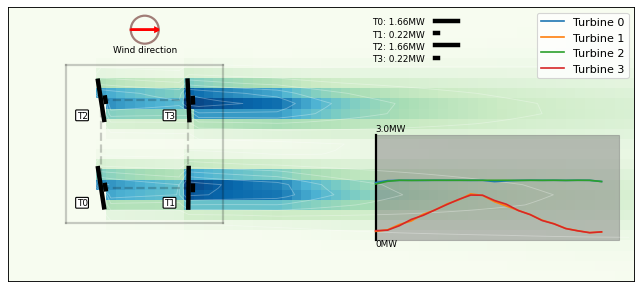

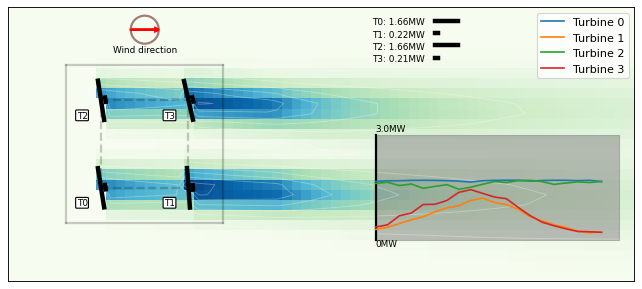

In [7]:
from serial_refine_agent import SR_ProportionalController
from env_utils import get_4wt_symmetric_env
from config import *
import numpy as np

# Load environment
env = get_4wt_symmetric_env(episode_length=EPISODE_LEN, privileged=False, changing_wind=True, action_representation="yaw",
    load_pyglet_visualization=True)

### Proportional controller
# Render
video = render_model(env, get_propSR_action(SR_ProportionalController()))
video[0].save("./figures/renders/eval/CW_PropSR.gif", save_all=True, append_images=video[1:], loop=0, duration=100)
# Evaluate
total_rewards, total_powers = evaluate_model(env, get_propSR_action(SR_ProportionalController()))
np.save("data/CW_PropSR_rewards.npy", total_rewards)
np.save("data/CW_PropSR_powers.npy", total_powers)

#### Noisy proportional controller
# Render
video = render_model(env, get_noisy_propSR_action(SR_ProportionalController()))
video[0].save("./figures/renders/eval/CW_NoisyPropSR.gif", save_all=True, append_images=video[1:], loop=0, duration=100)
# Evaluate
total_rewards, total_powers = evaluate_model(env, get_noisy_propSR_action(SR_ProportionalController()))
np.save("data/CW_NoisyPropSR_rewards.npy", total_rewards)
np.save("data/CW_NoisyPropSR_powers.npy", total_powers)

# Load environment
env = get_4wt_symmetric_env(episode_length=EPISODE_LEN, privileged=False, changing_wind=True,
    load_pyglet_visualization=True)

#### Naive agent
# Render
video = render_model(env, get_naive_action())
video[0].save("./figures/renders/eval/CW_Naive.gif", save_all=True, append_images=video[1:], loop=0, duration=100)
# Evaluate
total_rewards, total_powers = evaluate_model(env, get_naive_action())
np.save("data/CW_Naive_rewards.npy", total_rewards)
np.save("data/CW_Naive_powers.npy", total_powers)

#### Random agent
# Render
video = render_model(env, get_random_action())
video[0].save("./figures/renders/eval/CW_Random.gif", save_all=True, append_images=video[1:], loop=0, duration=100)
# Evaluate
total_rewards, total_powers = evaluate_model(env, get_random_action())
np.save("data/CW_Random_rewards.npy", total_rewards)
np.save("data/CW_Random_powers.npy", total_powers)


### [CW] PPO models

In [ ]:
from stable_baselines3 import PPO
from env_utils import get_4wt_symmetric_env
from config import *
from wind_processes import SetSequenceWindProcess
from PIL import Image
import numpy as np
import tqdm

model = PPO.load("data/models/from_server/2_PPO_4wt_symmetric_unprivileged_cw_1.00M")
# model = PPO.load("data/models/from_server/global_action_opt.zip") # action_representation="yaw",
# model = PPO.load("data/models/from_server/global_action_end.zip") # action_representation="yaw",

env = get_4wt_symmetric_env(episode_length=EPISODE_LEN, privileged=False, changing_wind=True, 
    load_pyglet_visualization=True)

#### Deterministic PPO
# Render
video = render_model(env, get_model_action(model))
video[0].save("./figures/renders/eval/CW_PPO.gif", save_all=True, append_images=video[1:], loop=0, duration=100)
# Evaluate
total_rewards, total_powers = evaluate_model(env, get_model_action(model))
np.save("data/CW_PPO_rewards.npy", total_rewards)
np.save("data/CW_PPO_powers.npy", total_powers)

# Nondeterministic PPO
# Render
video = render_model(env, get_nondeterministic_model_action(model))
video[0].save("./figures/renders/eval/CW_PPO_nondeterministic.gif", save_all=True, append_images=video[1:], loop=0, duration=100)
# Evaluate
total_rewards, total_powers = evaluate_model(env, get_nondeterministic_model_action(model))
np.save("data/CW_PPO_nondeterministic_rewards.npy", total_rewards)
np.save("data/CW_PPO_nondeterministic_powers.npy", total_powers)

### [DynOP] 4wt observation points | PropSR, Naive, Random

Wind farm bounds (min, max): (0, 0) (250.0, 250.0)
Dynamic state shape: (50, 50)


 10%|█         | 1/10 [00:26<04:02, 26.89s/it]

Episode 0 finished with reward 0.21280676153912947
Episode 0 finished with power 153220868.30817324


 20%|██        | 2/10 [00:39<02:30, 18.77s/it]

Episode 1 finished with reward 1.7648018805631864
Episode 1 finished with power 1270657354.0054946


 30%|███       | 3/10 [00:54<01:56, 16.61s/it]

Episode 2 finished with reward 1.4688271471849423
Episode 2 finished with power 1057555545.9731586


 40%|████      | 4/10 [01:04<01:24, 14.04s/it]

Episode 3 finished with reward 1.8765291370841213
Episode 3 finished with power 1351100978.7005672


 50%|█████     | 5/10 [01:15<01:05, 13.08s/it]

Episode 4 finished with reward 1.1280555071925342
Episode 4 finished with power 812199965.1786246


 60%|██████    | 6/10 [01:30<00:55, 13.78s/it]

Episode 5 finished with reward 0.11569053485394923
Episode 5 finished with power 83297185.09484345


 70%|███████   | 7/10 [01:40<00:37, 12.60s/it]

Episode 6 finished with reward 2.204006103124632
Episode 6 finished with power 1586884394.249735


 80%|████████  | 8/10 [01:51<00:23, 11.93s/it]

Episode 7 finished with reward 1.914010429226087
Episode 7 finished with power 1378087509.042783


 90%|█████████ | 9/10 [02:05<00:12, 12.56s/it]

Episode 8 finished with reward 0.38779759344432324
Episode 8 finished with power 279214267.27991277


100%|██████████| 10/10 [02:20<00:00, 14.09s/it]

Episode 9 finished with reward 1.4694123974965216
Episode 9 finished with power 1057976926.1974957
Wind farm bounds (min, max): (0, 0) (250.0, 250.0)
Dynamic state shape: (50, 50)



 10%|█         | 1/10 [00:16<02:32, 16.90s/it]

Episode 0 finished with reward 0.20747646105474382
Episode 0 finished with power 149383051.95941558


 20%|██        | 2/10 [00:28<01:48, 13.62s/it]

Episode 1 finished with reward 1.7721024709528537
Episode 1 finished with power 1275913779.0860548


 30%|███       | 3/10 [00:39<01:28, 12.66s/it]

Episode 2 finished with reward 1.4883066987989186
Episode 2 finished with power 1071580823.1352215


 40%|████      | 4/10 [00:50<01:11, 11.99s/it]

Episode 3 finished with reward 1.9231768075841935
Episode 3 finished with power 1384687301.4606192


 50%|█████     | 5/10 [01:03<01:00, 12.11s/it]

Episode 4 finished with reward 1.130210118150051
Episode 4 finished with power 813751285.0680368


 60%|██████    | 6/10 [01:29<01:08, 17.10s/it]

Episode 5 finished with reward 0.11287174023116336
Episode 5 finished with power 81267652.96643762


 70%|███████   | 7/10 [01:46<00:51, 17.10s/it]

Episode 6 finished with reward 2.243392897503876
Episode 6 finished with power 1615242886.2027907


 80%|████████  | 8/10 [02:05<00:34, 17.43s/it]

Episode 7 finished with reward 1.8865125321879006
Episode 7 finished with power 1358289023.1752882


 90%|█████████ | 9/10 [02:28<00:19, 19.22s/it]

Episode 8 finished with reward 0.3877346234789336
Episode 8 finished with power 279168928.90483224


100%|██████████| 10/10 [02:47<00:00, 16.78s/it]

Episode 9 finished with reward 1.4649689567057995
Episode 9 finished with power 1054777648.8281758



 10%|█         | 1/10 [00:21<03:16, 21.80s/it]

Episode 0 finished with reward 0.2071879632970228
Episode 0 finished with power 149175333.57385644


 20%|██        | 2/10 [00:36<02:23, 17.91s/it]

Episode 1 finished with reward 1.7301649829730252
Episode 1 finished with power 1245718787.7405782


 30%|███       | 3/10 [00:52<01:58, 16.88s/it]

Episode 2 finished with reward 1.4823635133960664
Episode 2 finished with power 1067301729.645168


 40%|████      | 4/10 [01:07<01:37, 16.21s/it]

Episode 3 finished with reward 1.8587382171714526
Episode 3 finished with power 1338291516.3634458


 50%|█████     | 5/10 [01:25<01:23, 16.77s/it]

Episode 4 finished with reward 1.0893011115080224
Episode 4 finished with power 784296800.2857763


 60%|██████    | 6/10 [01:47<01:13, 18.50s/it]

Episode 5 finished with reward 0.10938792896000044
Episode 5 finished with power 78759308.85120031


 70%|███████   | 7/10 [02:02<00:51, 17.24s/it]

Episode 6 finished with reward 2.192742356199212
Episode 6 finished with power 1578774496.4634326


 80%|████████  | 8/10 [02:16<00:32, 16.46s/it]

Episode 7 finished with reward 1.8969839524416463
Episode 7 finished with power 1365828445.7579856


 90%|█████████ | 9/10 [02:37<00:17, 17.71s/it]

Episode 8 finished with reward 0.3839067467241615
Episode 8 finished with power 276412857.6413964


100%|██████████| 10/10 [02:54<00:00, 17.45s/it]

Episode 9 finished with reward 1.4985814740553092
Episode 9 finished with power 1078978661.3198228


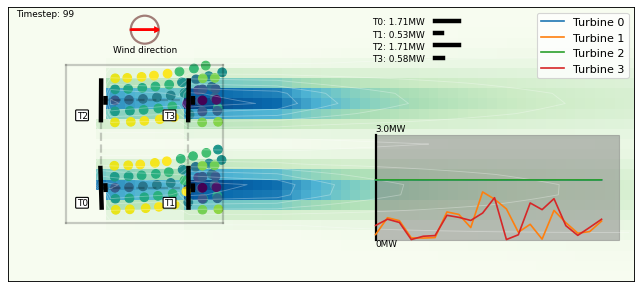

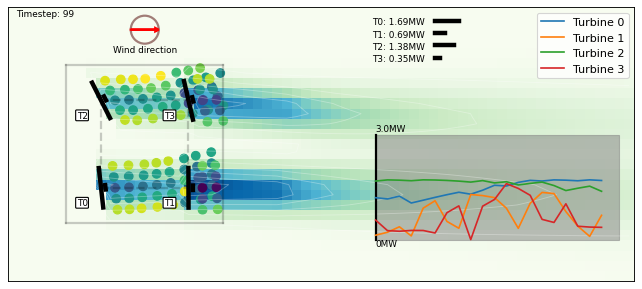

In [8]:
from serial_refine_agent import SR_ProportionalController
from env_utils import get_4wt_symmetric_env
from config import EPISODE_LEN
from wind_processes import SetSequenceWindProcess

import numpy as np
# Load environment
env = get_4wt_symmetric_env(
    episode_length=EPISODE_LEN, privileged=False, 
    changing_wind=True, action_representation="yaw",
    dynamic_mode="observation_points",
    load_pyglet_visualization=True)

#### PropSR
# Render
video = render_model(env, get_propSR_action(SR_ProportionalController()))
video[0].save("./figures/renders/eval/DynOP_PropSR.gif", save_all=True, append_images=video[1:], loop=0, duration=100)
# Evaluate
total_rewards, total_powers = evaluate_model(env, get_propSR_action(SR_ProportionalController()))
np.save("data/DynOP_PropSR_rewards.npy", total_rewards)
np.save("data/DynOP_PropSR_powers.npy", total_powers)

# Load environment
env = get_4wt_symmetric_env(
    episode_length=EPISODE_LEN, privileged=False, 
    changing_wind=True,
    dynamic_mode="observation_points",
    load_pyglet_visualization=True)

#### Naive
# Render
video = render_model(env, get_naive_action())
video[0].save("./figures/renders/eval/DynOP_Naive.gif", save_all=True, append_images=video[1:], loop=0, duration=100)
# Evaluate
total_rewards, total_powers = evaluate_model(env, get_naive_action())
np.save("data/DynOP_Naive_rewards.npy", total_rewards)
np.save("data/DynOP_Naive_powers.npy", total_powers)

#### Random
# Render
video = render_model(env, get_random_action())
video[0].save("./figures/renders/eval/DynOP_Random.gif", save_all=True, append_images=video[1:], loop=0, duration=100)
# Evaluate
total_rewards, total_powers = evaluate_model(env, get_random_action())
np.save("data/DynOP_Random_rewards.npy", total_rewards)
np.save("data/DynOP_Random_powers.npy", total_powers)

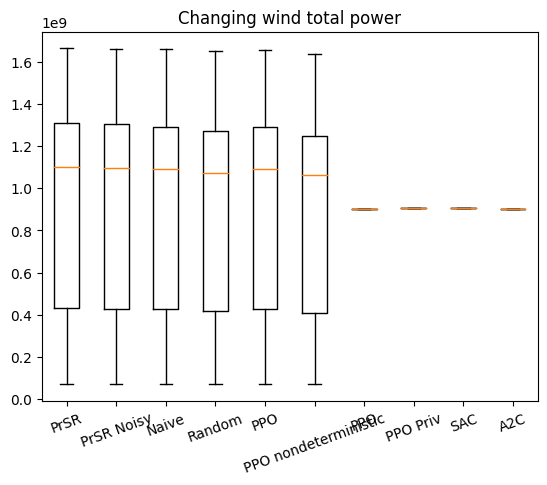

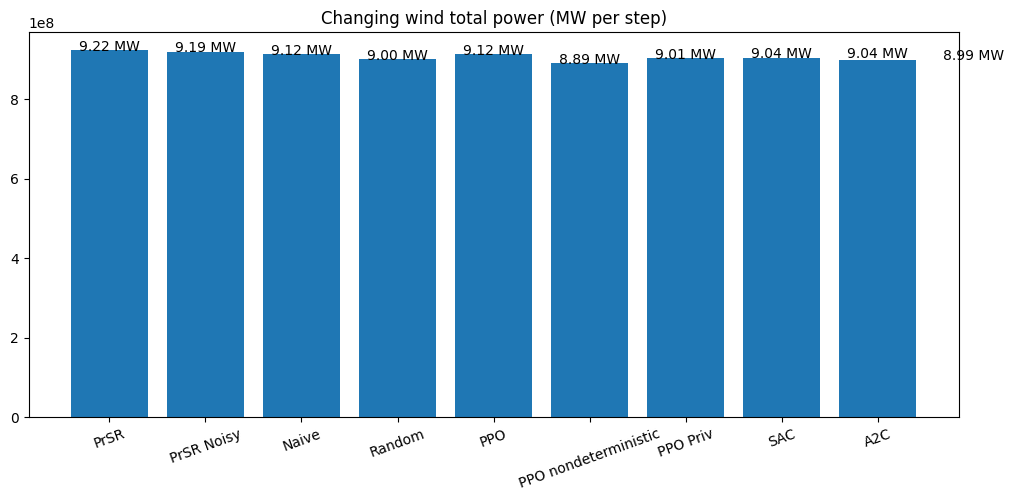

Changing wind total power
PrSR 921895446.4883407
PrSR Noisy 919295336.772414
Naive 911956827.8724827
Random 899674244.2780787
PPO 911995414.1753166
PPO nondeterministic 889358753.7655661
PPO 900700000.0
PPO Priv 903999999.9999999
SAC 903999999.9999999
A2C 899000000.0


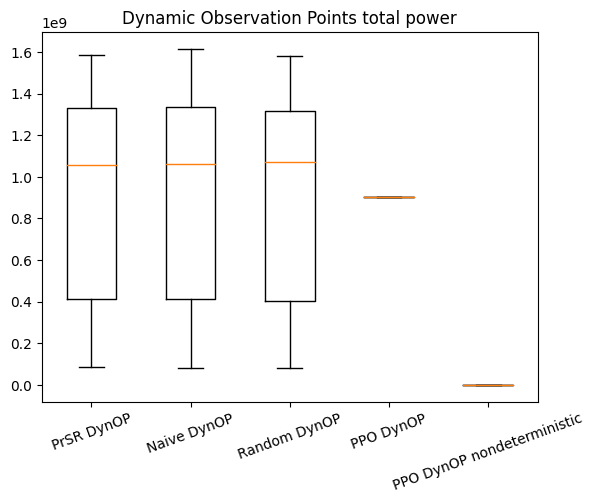

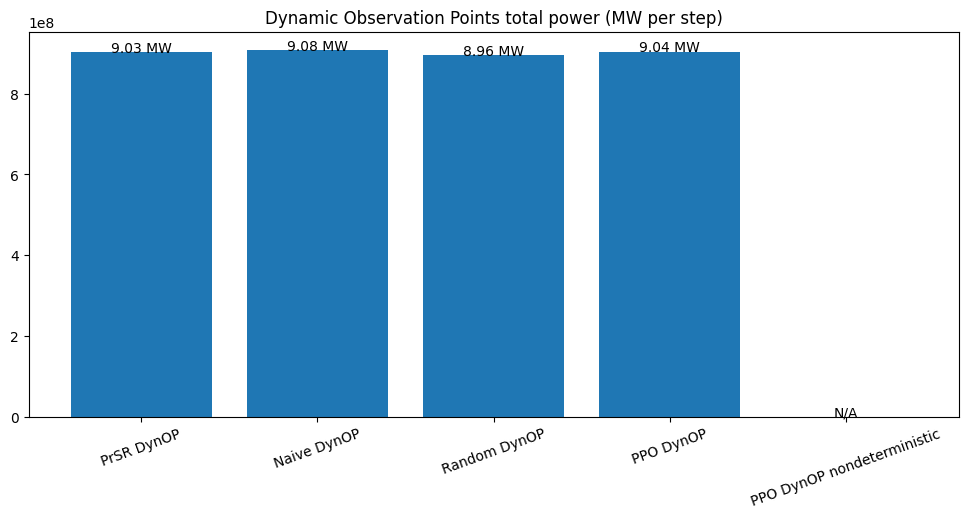

Dynamic Observation Points total power
PrSR DynOP 903019499.4030788
Naive DynOP 908406238.0786871
Random DynOP 896353793.7642663
PPO DynOP 903999999.9999999
PPO DynOP nondeterministic 0.0


In [9]:
# Plot results
import matplotlib.pyplot as plt
import numpy as np

# # Fixed wind results
# fw_greedy_power = np.load("data/FW_greedy_powers.npy")
# fw_propsr_power = np.load("data/FW_SR_proportional_powers.npy")
# # fw_propsr_noisy_power = np.load("data/FW_SR_proportional_noisy_powers.npy")
# fw_names = ["PrSR", "Greedy"]
# fw_data = [fw_propsr_power.sum(axis=1), fw_greedy_power.sum(axis=1)]

# Changing wind results
cw_propsr_power = np.load("data/CW_PropSR_powers.npy")
cw_propsr_noisy_power = np.load("data/CW_NoisyPropSR_powers.npy")
cw_naive_power = np.load("data/CW_Naive_powers.npy")
cw_random_power = np.load("data/CW_Random_powers.npy")
cw_ppo_local = np.load("data/CW_PPO_powers.npy")
cw_ppo_nondeterministic = np.load("data/CW_PPO_nondeterministic_powers.npy")
cw_names = ["PrSR", "PrSR Noisy", "Naive", "Random"] + ["PPO", "PPO nondeterministic", "PPO", "PPO Priv", "SAC", "A2C"]
cw_data = [cw_propsr_power.sum(axis=1), cw_propsr_noisy_power.sum(axis=1), cw_naive_power.sum(axis=1), cw_random_power.sum(axis=1)] + [cw_ppo_local.sum(axis=1), cw_ppo_nondeterministic.sum(axis=1), 9.007 * 1e8, 9.04 * 1e8, 9.04 * 1e8, 8.99 * 1e8]

# Dynamic Observation Points results
dyn_propsr_power = np.load("data/DynOP_PropSR_powers.npy")
dyn_naive_power = np.load("data/DynOP_Naive_powers.npy")
dyn_random_power = np.load("data/DynOP_Random_powers.npy")
dyn_names = ["PrSR DynOP", "Naive DynOP", "Random DynOP"] + ["PPO DynOP", "PPO DynOP nondeterministic"]
dyn_data = [dyn_propsr_power.sum(axis=1), dyn_naive_power.sum(axis=1), dyn_random_power.sum(axis=1)] + [9.04 * 1e8, 0]

# Plotting a boxplot, a barplot and printing the results
for data, names, title in [(cw_data, cw_names, "Changing wind total power"), 
                           (dyn_data, dyn_names, "Dynamic Observation Points total power")]:
    plt.boxplot(data)
    plt.xticks(np.arange(len(names))+1, names)
    plt.xticks(rotation=20)
    plt.title(title)
    plt.show()

    # Mean power barplot
    # long figure
    plt.figure(figsize=(12, 5))
    plt.bar(names, [np.mean(d) for d in data])
    for i, d in enumerate(data):
        if np.mean(d) == 0:
            plt.text(i, 0, "N/A", ha="center")
        else:
            plt.text(i, np.mean(d), f"{round(np.mean(d/1e6 / 100), 2):.02f} MW", ha="center")
    plt.title(f"{title} (MW per step)")
    plt.xticks(rotation=20)
    plt.show()

    # Print results 
    print(title)
    for name, d in zip(names, data):
        print(name, np.mean(d))

In [ ]:
# Plot results
import matplotlib.pyplot as plt
import numpy as np

rewards = np.load("data/SR_proportional_rewards.npy")
noisy_rewards = np.load("data/SR_proportional_noisy_rewards.npy")
dyn_observation_points_rewards = np.load("data/SR_proportional_dyn_observation_points_rewards.npy")

# Barplot of mean total rewards
power = np.load("data/SR_proportional_powers.npy")
noisy_power = np.load("data/SR_proportional_noisy_powers.npy")
greedy_power = np.load("data/greedy_cw_powers.npy")
dyn_observation_points_power = np.load("data/SR_proportional_dyn_observation_points_powers.npy")
greedy_dyn_observation_points_power = np.load("data/greedy_dyn_observation_points_powers.npy")
total_powers = np.sum(power, axis=1)
total_noisy_powers = np.sum(noisy_power, axis=1)
total_greedy_powers = np.sum(greedy_power, axis=1)
total_dyn_observation_points_powers = np.sum(dyn_observation_points_power, axis=1)
total_greedy_dyn_observation_points_powers = np.sum(greedy_dyn_observation_points_power, axis=1)
names_cw = ["PrSR", "PrSR Noisy", "Greedy"] + ["PPO", "PPO Priv"]
data_cw = [total_powers, total_noisy_powers, total_greedy_powers] + [9.007 * 1e8, 9.04 * 1e8]

names_dynop = ["PrSR DynOP", "Greedy DynOP"] + ["PPO", "PPO Priv"]
data_dynop = [total_dyn_observation_points_powers, total_greedy_dyn_observation_points_powers] + [9.04 * 1e8, 0]

# power over time
plt.plot(np.mean(power, axis=0), label="PrSR")
plt.plot(np.mean(noisy_power, axis=0), label="PrSR Noisy")
plt.plot(np.mean(dyn_observation_points_power, axis=0), label="PrSR DynOP")
plt.plot(np.mean(greedy_dyn_observation_points_power, axis=0), label="Greedy DynOP")
plt.legend()
plt.show()

#### BOXPLOTS ####
# Changing wind power
plt.boxplot(data_cw)
plt.xticks(np.arange(len(names_cw))+1, names_cw)
plt.xticks(rotation=20)
plt.title("Changing wind total power")
plt.show()

# Dynamic Observation Points power
plt.boxplot(data_dynop)
plt.xticks(np.arange(len(names_dynop))+1, names_dynop)
plt.xticks(rotation=20)
plt.title("Dynamic Observation Points total power")
plt.show()

#### MEAN POWER BARPLOT ####
# Changing wind mean power
plt.bar(names_cw, [np.mean(d) for d in data_cw])
for i, d in enumerate(data_cw):
    plt.text(i, np.mean(d), f"{round(np.mean(d/1e6 / 100), 2):.02f} MW", ha="center")
plt.title("Changing wind mean power (MW per step)")
plt.xticks(rotation=20)
plt.show()

# Dynamic Observation Points mean power
plt.bar(names_dynop, [np.mean(d) for d in data_dynop])
for i, d in enumerate(data_dynop):
    plt.text(i, np.mean(d), f"{round(np.mean(d/1e6 / 100), 2):.02f} MW", ha="center")
plt.title("Dynamic Observation Points mean power (MW per step)")
plt.xticks(rotation=20)
plt.show()

print("Mean total rewards")
print("PropSR Power:", np.mean(total_powers))
print("PropSR Noisy Power:", np.mean(total_noisy_powers))
print("Greedy Power:", np.mean(total_greedy_powers))
print("PropSR DynOP Rewards:", np.mean(total_dyn_observation_points_powers))
print("Greedy DynOP Rewards:", np.mean(total_greedy_dyn_observation_points_powers))

### Render envs

In [ ]:

# Load agent and environment
env = get_4wt_symmetric_env(
    episode_length=EPISODE_LEN, privileged=False, 
    changing_wind=True, dynamic_mode="observation_points", load_pyglet_visualization=True)

# --- Render agents ---

# Load proportional agent
agent = SR_ProportionalController()
env.wind_process = SetSequenceWindProcess(wind_speeds=render_wind_speeds, wind_directions=render_wind_directions)
for j in range(EPISODE_LEN):
    wind_direction = env.wind_process.wind_direction
    current_yaws = env.yaws_from_wind
    action = agent.predict(wind_direction, current_yaws)
    obs, reward, terminated, truncated, info = env.step(action)
    env.render()

# Greedy agent
env.wind_process = SetSequenceWindProcess(wind_speeds=render_wind_speeds, wind_directions=render_wind_directions)
for j in range(EPISODE_LEN):
    action = np.zeros_like(env.yaws_from_wind)
    obs, reward, terminated, truncated, info = env.step(action)
    env.render()